## Setup

In [4]:
try:
  from nlpcw.utils import get_dataset, show_random_elements
  from transformers import AutoTokenizer
  import matplotlib.pyplot as plt
  import seaborn as sns
  from collections import Counter
  from itertools import combinations
  import numpy as np
  import pandas as pd
  import wandb
except:
  %pip install -q "git+https://github.com/cogniveon/nlpcw.git"

In [19]:
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("rohit-k-kesavan/COMM061-NLP-CW")

summary_list, config_list, name_list = [], [], []
for run in runs:
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)


def map_summary_to_columns(
    df,
    summary_keys: list[str] = ["eval/f1", "eval/loss", "eval/precision", "eval/recall", "eval/accuracy", "train/loss", "train/epoch"],
    config_keys: list[str] = ["per_device_train_batch_size", "learning_rate", "weight_decay", "model/num_parameters",  "optim", "lr_scheduler_type"]
):
  new_df = df.copy()
  for key in summary_keys:
    new_df[key] = df['summary'].apply(lambda x: x.get(key))
  for key in config_keys:
    new_df[key] = df['config'].apply(lambda x: x.get(key))
  new_df.drop(columns=['summary', 'config'], inplace=True)
  return new_df


runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })

runs_df = map_summary_to_columns(runs_df)

model_exps = [
  "romainlhardy-roberta-large-finetuned-ner",
  "google-bert-bert-base-uncased",
  "google-bert-bert-large-uncased",
  "pucpr-biobertpt-all",
  "romainlhardy-finetuned-ner",
]

model_exps_df = runs_df[runs_df["name"].isin(model_exps)]
optuna_exps_df = runs_df[~runs_df["name"].isin(model_exps)]

## Plots

In [20]:
model_exps_df

,name,eval/f1,eval/loss,eval/precision,eval/recall,eval/accuracy,train/loss,train/epoch,per_device_train_batch_size,learning_rate,weight_decay,model/num_parameters,optim,lr_scheduler_type
0,romainlhardy-roberta-large-finetuned-ner,0.944804,0.209842,0.948358,0.941276,0.939251,0.1542,20,8,0.000001,0.001,354314244,adamw_torch,linear
1,google-bert-bert-base-uncased,0.913392,0.266949,0.916196,0.910605,0.908536,0.3481,15,8,0.000001,0.001,108894724,adamw_torch,linear
2,google-bert-bert-large-uncased,0.920609,0.243737,0.923205,0.918027,0.917545,0.2277,19,8,0.000001,0.001,334096388,adamw_torch,linear
3,pucpr-biobertpt-all,0.917582,0.262461,0.921143,0.914048,0.911317,0.3196,15,8,0.000001,0.001,177265924,adamw_torch,linear
4,romainlhardy-finetuned-ner,0.922593,0.241025,0.926306,0.918910,0.917798,0.2350,19,8,0.000001,0.001,107722756,adamw_torch,linear


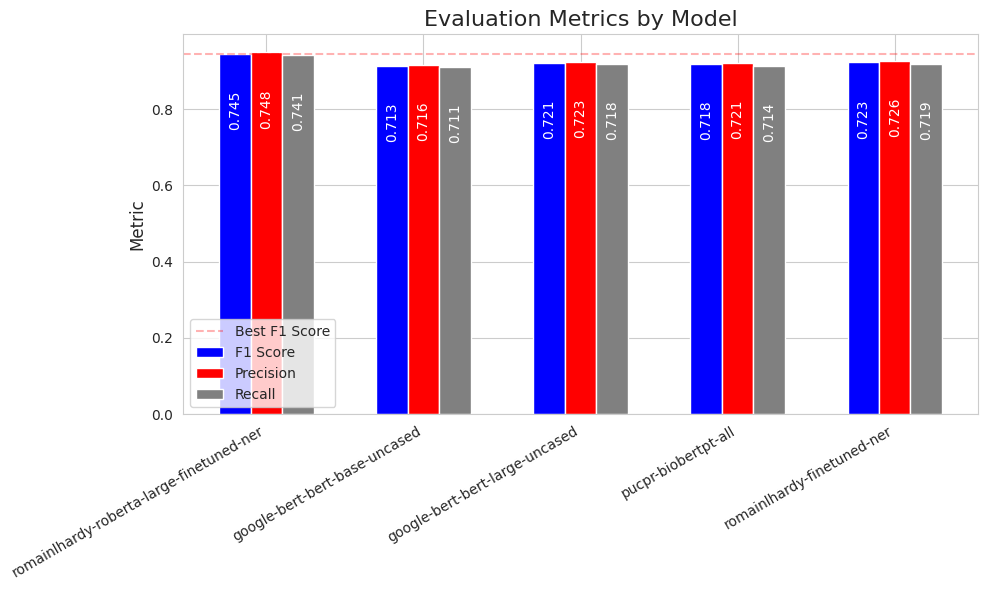

In [61]:
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.2
eval_positions = np.arange(len(model_exps_df['name']))
precision_positions = eval_positions + bar_width
recall_positions = eval_positions + 2 * bar_width

f1_bars = ax.bar(eval_positions, model_exps_df['eval/f1'], bar_width, label='F1 Score', color="blue")
precision_bars = ax.bar(precision_positions, model_exps_df['eval/precision'], bar_width, label='Precision', color="red")
recall_bars = ax.bar(recall_positions, model_exps_df['eval/recall'], bar_width, label='Recall', color="gray")

for bars, metric in zip([f1_bars, precision_bars, recall_bars], ['eval/f1', 'eval/precision', 'eval/recall']):
    for bar in bars:
        yval = bar.get_height() - 0.2
        ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.3f}',
                ha='center', va='bottom', fontsize=10, color="white", rotation="vertical")

best_f1_score = model_exps_df['eval/f1'].max()
ax.axhline(y=best_f1_score, color='red', linestyle='--', alpha=0.3, label='Best F1 Score')

ax.set_title('Evaluation Metrics by Model', fontsize=16)
ax.set_ylabel('Metric', fontsize=12)
# ax.set_xlabel('Model Name', fontsize=12)
ax.set_xticks(eval_positions + bar_width)  # Center the x-ticks between the bars
ax.set_xticklabels(model_exps_df['name'], rotation=30, ha='right', fontsize=10)
ax.legend()

plt.tight_layout()
plt.show()

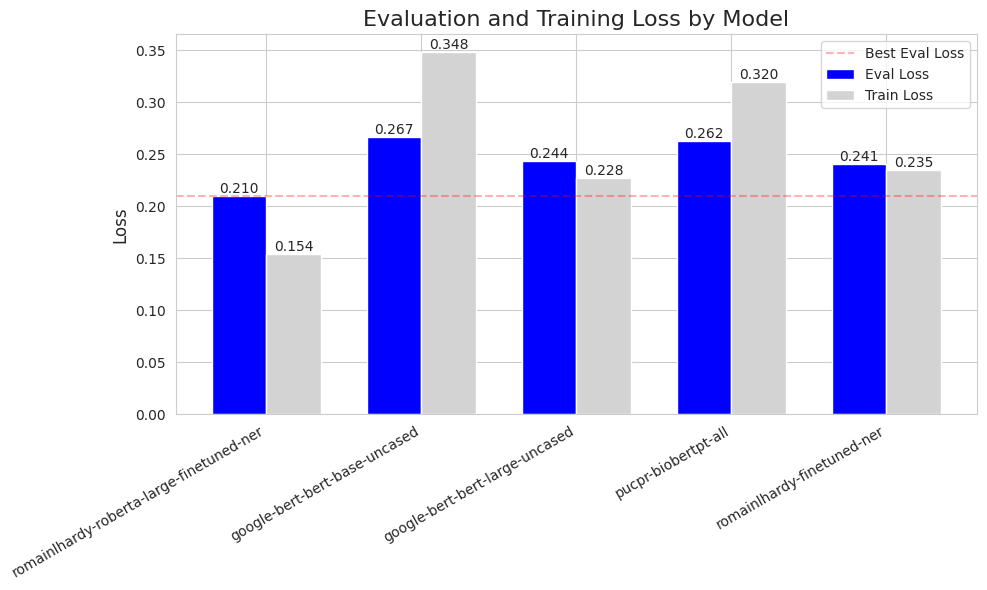

In [63]:
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
eval_positions = np.arange(len(model_exps_df['name']))
train_positions = eval_positions + bar_width

eval_bars = ax.bar(eval_positions, model_exps_df['eval/loss'], bar_width, label='Eval Loss', color="blue")
train_bars = ax.bar(train_positions, model_exps_df['train/loss'], bar_width, label='Train Loss', color="lightgray")

for bar in eval_bars + train_bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.3f}',
            ha='center', va='bottom', fontsize=10)

best_eval_loss = model_exps_df['eval/loss'].min()
ax.axhline(y=best_eval_loss, color='red', linestyle='--', alpha=0.3, label='Best Eval Loss')

ax.set_title('Evaluation and Training Loss by Model', fontsize=16)
ax.set_ylabel('Loss', fontsize=12)
# ax.set_xlabel('Model Name', fontsize=12)
ax.set_xticks(eval_positions + bar_width / 2)  # Center the x-ticks between the bars
ax.set_xticklabels(model_exps_df['name'], rotation=30, ha='right', fontsize=10)
ax.legend()

plt.tight_layout()
plt.show()


In [57]:
optuna_exps_df

,name,eval/f1,eval/loss,eval/precision,eval/recall,eval/accuracy,train/loss,train/epoch,per_device_train_batch_size,learning_rate,weight_decay,model/num_parameters,optim,lr_scheduler_type
5,wild-pond-17,0.946273,0.234263,0.950977,0.941616,0.940510,0.1148,8,8,0.000004,0.003131,354314244,adamw_torch,linear
6,fluent-sunset-18,0.955535,0.323089,0.961030,0.950102,0.948694,0.0113,10,12,0.000035,0.005490,354314244,adamw_torch,linear
7,pleasant-violet-19,0.955076,0.315100,0.959411,0.950781,0.948851,0.0144,10,8,0.000031,0.007522,354314244,adamw_torch,linear
8,polar-vortex-20,0.944724,0.204633,0.948196,0.941276,0.938936,0.1758,14,8,0.000001,0.004573,354314244,adamw_torch,linear
9,eager-valley-21,0.955247,0.350624,0.959582,0.950950,0.948851,0.0123,12,8,0.000030,0.000384,354314244,adamw_torch,linear
10,worthy-rain-22,0.943399,0.193605,0.950551,0.936354,0.937834,0.2560,1,8,0.000023,0.009967,354314244,adamw_torch,linear
11,confused-silence-23,0.953453,0.334989,0.957862,0.949084,0.947749,0.0067,18,4,0.000084,0.003370,354314244,adamw_torch,linear
12,denim-hill-24,0.947243,0.255295,0.951378,0.943143,0.941139,0.1140,10,4,0.000002,0.009390,354314244,adamw_torch,linear
13,floral-fire-25,0.945851,0.312933,0.950471,0.941276,0.940667,0.0370,9,12,0.000066,0.005694,354314244,adamw_torch,linear
14,easy-sponge-26,0.939451,0.214181,0.949549,0.929566,0.932169,0.2542,1,4,0.000019,0.001901,354314244,adamw_torch,linear
